**CANNY DETEKCIJA TABLE**

Ovo je kompletan pipeline za detekciju šahovske table na slikama i kvantitativnu evaluaciju te detekcije u odnosu na ground-truth anotacije.

U prvom delu se učitavaju sve slike iz zadatog direktorijuma (DATA_DIR) i definišu pomoćne funkcije za prikaz slika i standardizaciju redosleda temena četvorougla (TL–TR–BR–BL). Zatim sledi glavna funkcija detect_chessboard_quad, koja radi detekciju table klasičnim OpenCV pristupom: slika se prevodi u grayscale, bluruje, izvlače se ivice Canny algoritmom, a zatim se primenjuju morfološke operacije (close + dilate) da bi se ivice povezale u stabilne konture. Nakon toga se iz skupa kontura bira najbolji kandidat za tablu tako što se traži konveksan četvorougao dovoljno velike površine (u odnosu na celu sliku), a kandidat se rangira kombinacijom kriterijuma: velika površina, dobra pravougaonost i tolerisan odnos stranica. Rezultat detekcije se vizualizuje crtanjem četvorougla i uglova preko originalne slike.

U drugom delu učitavaju se COCO anotacije (_annotations.coco.json) i za svaku sliku se pronalazi pripadajući image_id i odgovarajuće anotacije. Ground-truth tabla se bira kao anotacija najveće površine. GT i predikcija se zatim pretvaraju u binarne maske: GT prvenstveno iz segmentation poligona, a kao fallback iz bbox, dok se predikcija formira popunjavanjem poligona predikovanog četvorougla. Na osnovu tih maski računa se IoU (Intersection over Union) za svaku sliku, rezultati se smeštaju u DataFrame, štampaju se agregatne metrike (mean/median IoU, procenat uspešnih detekcija) i prikazuju se najbolje/najgore slike po IoU.

Na kraju, fajl sadrži deo za analizu grešaka: za nekoliko najgorih slučajeva prikazuje se overlay gde su GT i predikcija obojeni različito, kao i posebne maske “samo GT” (promašeni delovi) i “samo Pred” (višak detekcije), što olakšava dijagnostiku tipičnih problema.
Dodatno, rezultati se čuvaju u CSV fajl radi poređenja različitih podešavanja parametara, i crta se histogram raspodele IoU vrednosti kroz dataset.

Broj slika: 329
Primeri: ['/content/soft-canny/00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.UeIalh1bhfXlMPNMd9qy.jpg', '/content/soft-canny/0115e4df73475b550e5c6f7a88b2474f_jpg.rf.MGZokKOBcnlIjJhSCpJy.jpg', '/content/soft-canny/02f0931b536dfba10affc3231a3d64fb_jpg.rf.TgCy7CjpH8A0dUYPHOxd.jpg', '/content/soft-canny/0301b7f9ed4d5ba503fda79fc4370c29_jpg.rf.F3nEFKMliFZXsjGVWSFL.jpg', '/content/soft-canny/03886821377011fec599e8fa12d86e89_jpg.rf.zQhDHVTwrax80bl2kdsc.jpg']


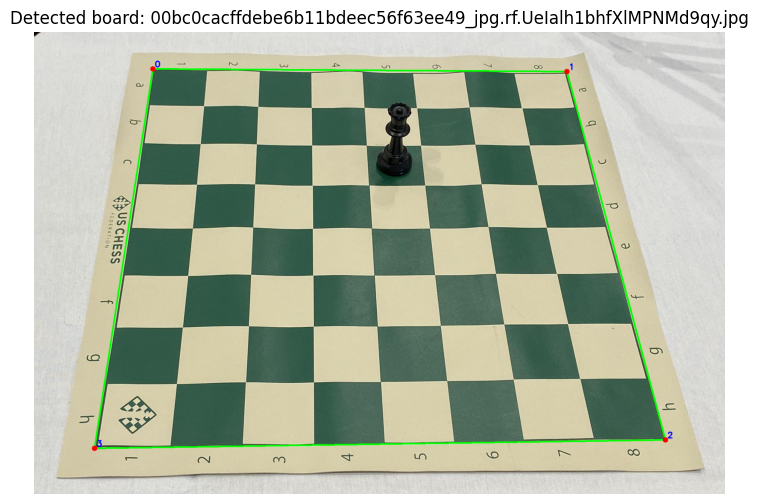

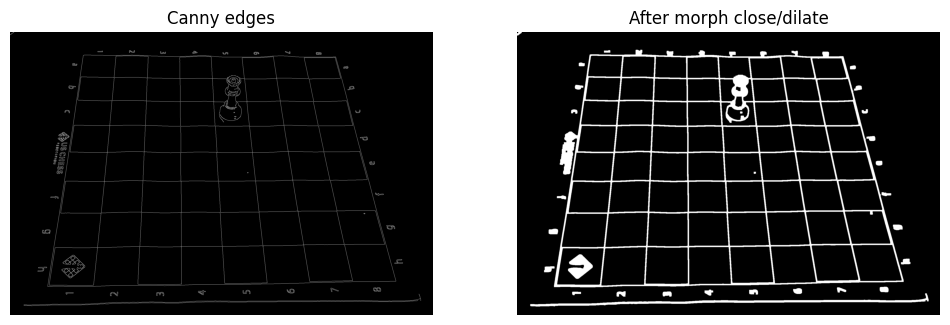

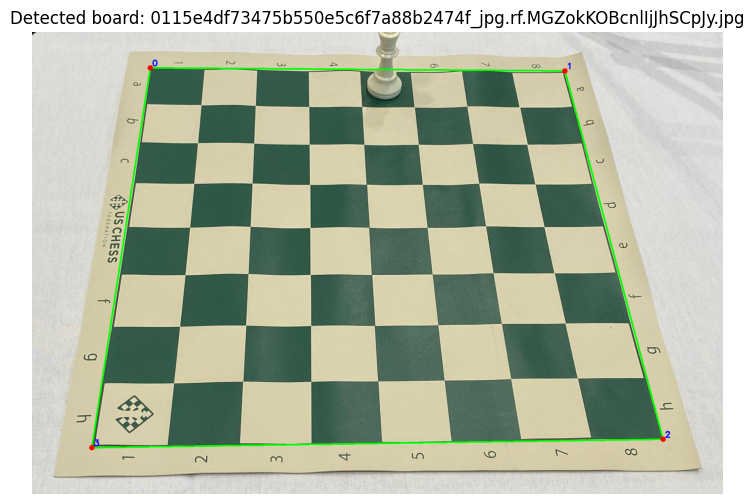

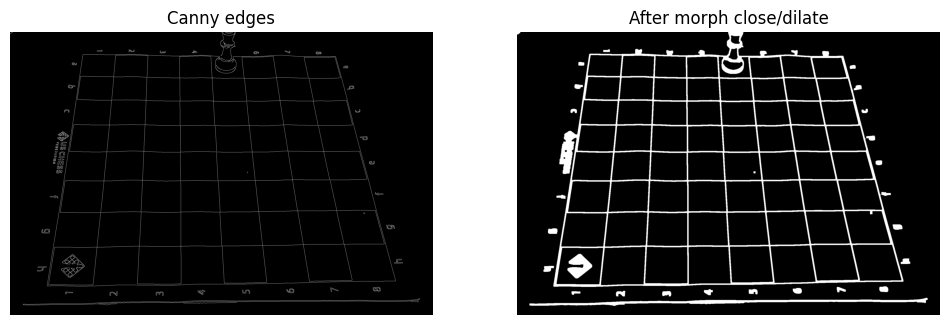

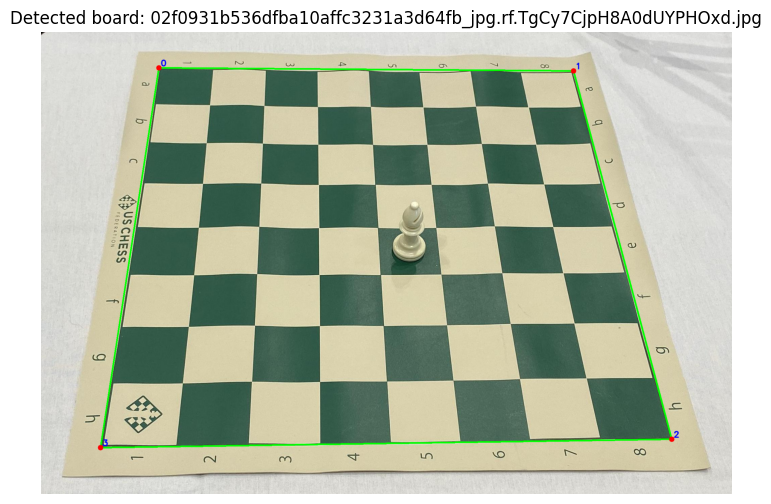

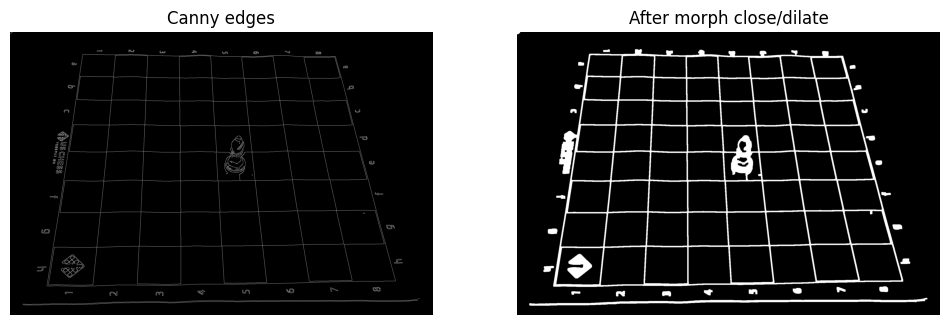

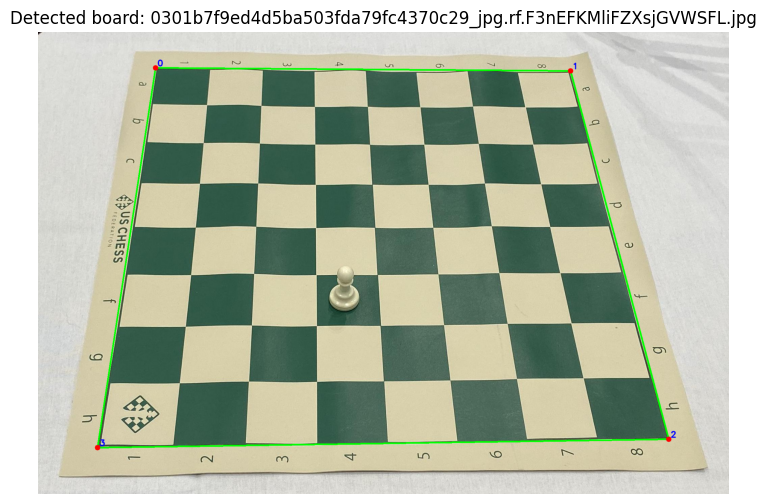

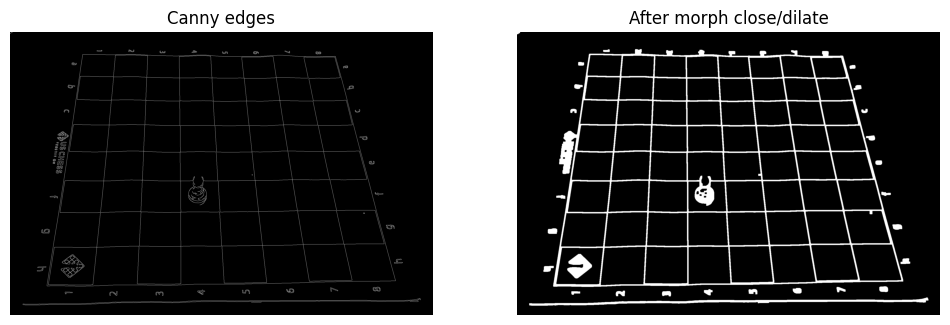

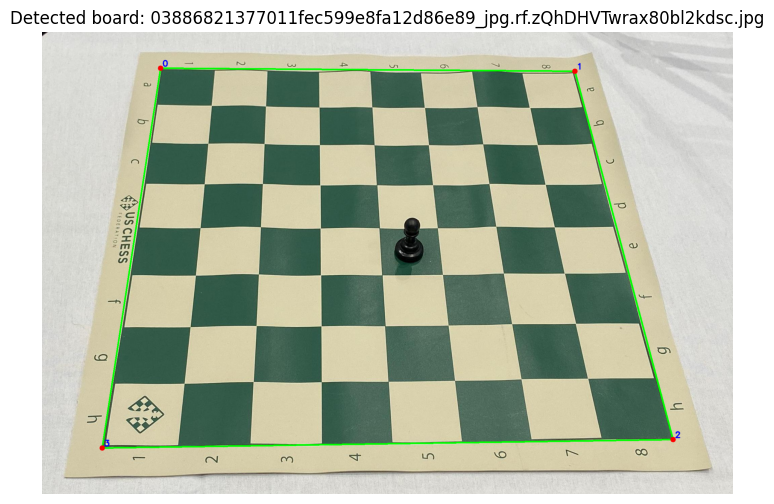

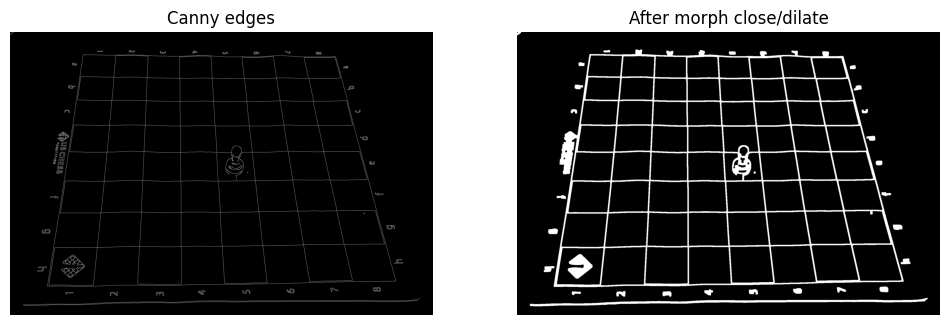

Ukupno vreme za sve slike: 23890.9 ms (23.89 s)
Ukupno slika: 329
Valid IoU slika: 329
Mean IoU: 0.8722303577582093
Median IoU: 0.9886374338660979
Predikcija uspešna (quad != None): 0.9027355623100304

Najgore (IoU):


file  iou  has_pred
203  IMG_4004_jpg.rf.AXxCcLS4LiGr7P585iTZ.jpg  0.0     False
204  IMG_4005_jpg.rf.5yAjSsqoVmlrtDgOPEow.jpg  0.0     False
205  IMG_4008_jpg.rf.nOLg5rqbflDbD4IlQLzM.jpg  0.0     False
206  IMG_4009_jpg.rf.7X6vVZhSq4yfxVYD8s3I.jpg  0.0     False
209  IMG_4015_jpg.rf.B1KX7ClQcG4GK8RNL5lw.jpg  0.0     False


Najbolje (IoU):


file       iou  has_pred
281  d3a4e1b8f13ef89f419251f5c5839d0d_jpg.rf.f4xGU3...  0.998245      True
15   0b4ba28f0c759a11750a6430649b52e3_jpg.rf.JaTgl9...  0.998101      True
11   06770ce99d4866165c0dfb104179c361_jpg.rf.hU9M7o...  0.997401      True
320  f52e1873b8583f8bf4f7ddf6e9649f07_jpg.rf.VHTXW0...  0.996954      True
274  cf4769d0586df6b3fb0dc618d9f8abe6_jpg.rf.22nCNp...  0.996748      True

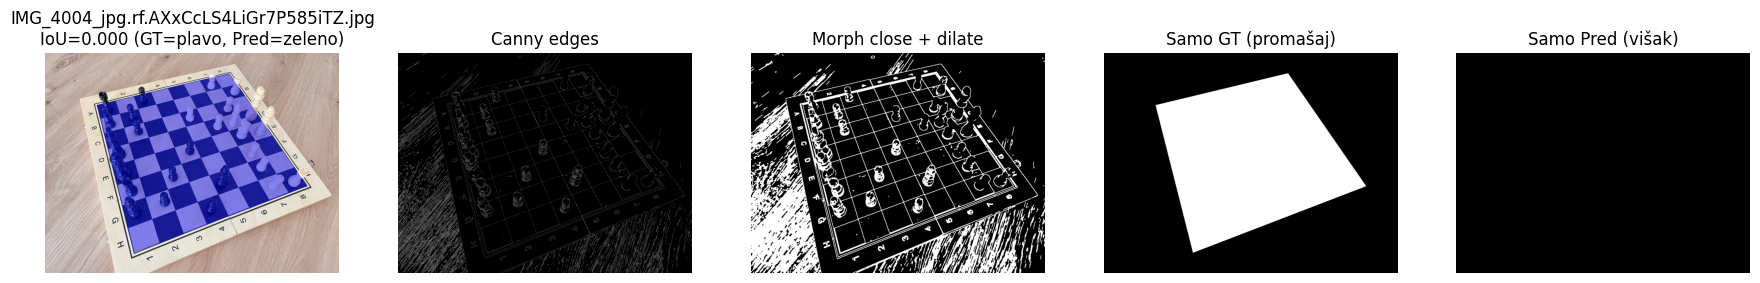

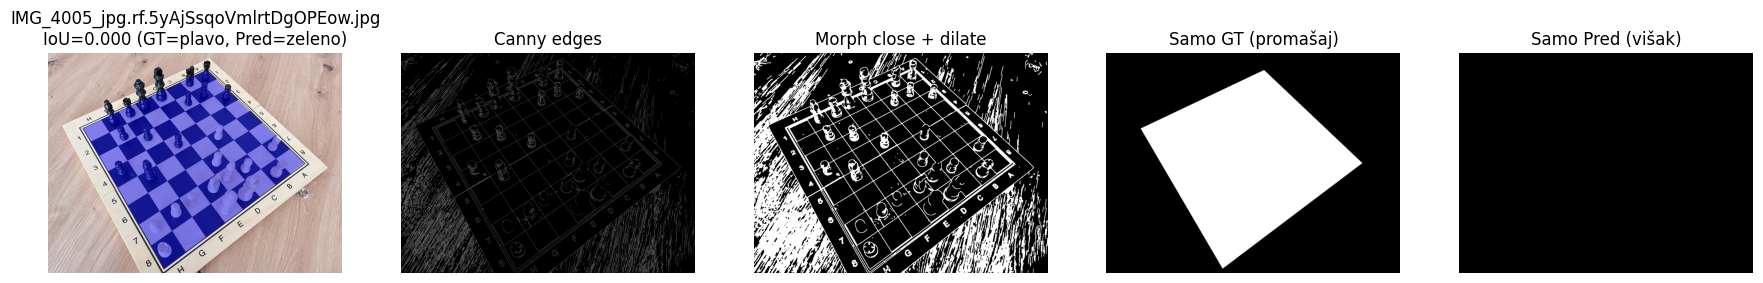

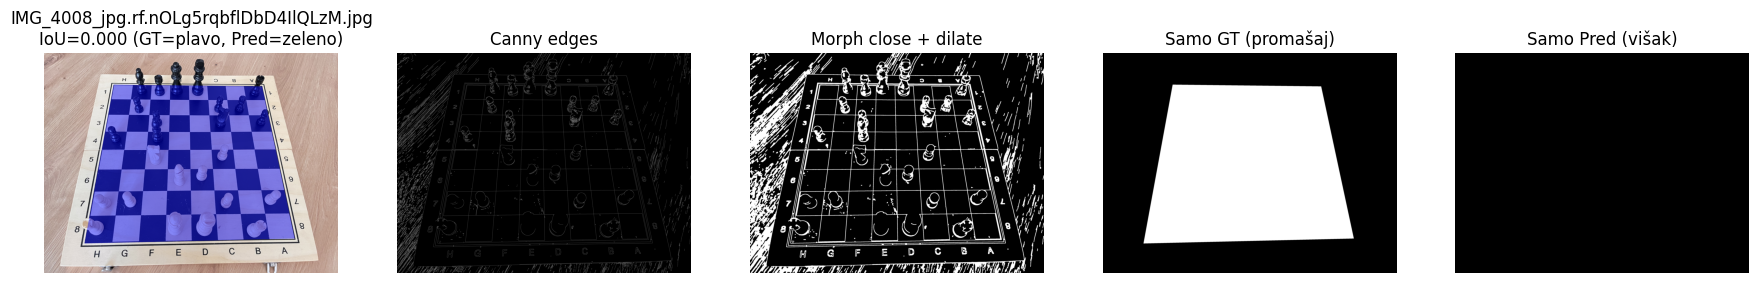


--- IoU SUMMARY (ceo dataset) ---
Broj slika sa GT: 329
Mean IoU: 0.8722303577582093
Median IoU: 0.9886374338660979
Min IoU: 0.0
Max IoU: 0.9982453765795918
Pct IoU >= 0.99: 0.432
Pct IoU >= 0.95: 0.769
Pct IoU >= 0.90: 0.878
Pct IoU >= 0.85: 0.878
Pct IoU >= 0.80: 0.878
Saved: /content/iou_results_canny.csv


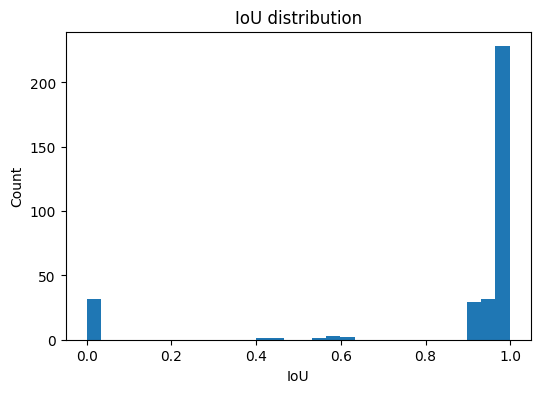

In [6]:
!pip -q install opencv-python-headless matplotlib

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import time

DATA_DIR = "/content/soft-canny"

IMG_GLOBS = ["*.jpg", "*.jpeg", "*.png", "*.webp"]

# 1) Load images - Prolazi kroz folder i vraća listu putanja do svih slika, sortiranu.
def list_images(data_dir):
    paths = []
    for g in IMG_GLOBS:
        paths.extend(glob.glob(os.path.join(data_dir, g)))
    return sorted(paths)

# 2) Show images - Prikazuje sliku uz naslov
def show_bgr(img_bgr, title="", figsize=(10,6)):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 3) Order points (TL, TR, BR, BL) - Uređuje 4 tačke četvorougla u standardnom redosledu: gore-levo (TL), gore-desno (TR), dole-desno (BR), dole-levo (BL).
def order_points(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

# 4) Core: Canny -> konture -> najbolji četvorougao
#Glavna detekcija table: pretvara sliku u grayscale, zamuti, radi Canny ivice, “zatvara rupe” morfologijom (close + dilate), nalazi konture i bira najbolji konveksni četvorougao (po površini + “pravougaonosti” + penalizaciji prevelikog odnosa stranica).
#Vraća pronađeni quad i debug (edges, closed, konture, najbolji kandidat).
def detect_chessboard_quad(img_bgr,canny1=50, canny2=150,blur_ksize=5,morph_ksize=7,min_area_ratio=0.08):

    h, w = img_bgr.shape[:2]
    img_area = h * w

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    edges = cv2.Canny(gray, canny1, canny2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_ksize, morph_ksize))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    closed = cv2.dilate(closed, kernel, iterations=1)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best = None
    best_score = -1
    best_approx = None

    min_area = min_area_ratio * img_area

    for cnt in contours:
        area = cv2.contourArea(cnt)
        # ignorisu se male povrsine, posto je tabla velika
        if area < min_area:
            continue

        peri = cv2.arcLength(cnt, True)
        # probava se više epsilona da bi se lakše uhvatila sva 4 temena
        for eps_ratio in [0.01, 0.015, 0.02, 0.03, 0.04]:
            approx = cv2.approxPolyDP(cnt, eps_ratio * peri, True)
            if len(approx) == 4 and cv2.isContourConvex(approx):
                # score: preferiraj velike, "pravougaone" oblike
                approx_pts = approx.reshape(4, 2)
                rect = cv2.minAreaRect(approx_pts.astype(np.float32))
                box = cv2.boxPoints(rect)
                box_area = cv2.contourArea(box)

                if box_area <= 1:
                    continue

                rectangularity = float(area) / float(box_area)  # ~1 ako je lepo "pravougaono"
                # penalizuju se previše tanki oblici
                (rw, rh) = rect[1]
                if rw <= 1 or rh <= 1:
                    continue
                aspect = max(rw, rh) / min(rw, rh)

                # tabla je često približno kvadratna, ali zbog perspektive može odstupati
                aspect_penalty = 1.0 / (1.0 + max(0.0, aspect - 2.2))  # tolerancija do ~2.2

                score = area * rectangularity * aspect_penalty

                if score > best_score:
                    best_score = score
                    best = cnt
                    best_approx = approx_pts

    debug = {
        "edges": edges,
        "closed": closed,
        "contours": contours,
        "best_contour": best,
        "best_approx": best_approx
    }

    if best_approx is None:
        return None, debug

    quad = order_points(best_approx)
    return quad, debug

# 5) Vizualizacija rezultata - Crta pronađeni četvorougao (ivice) preko slike
def draw_quad(img_bgr, quad, color=(0,255,0), thickness=3):
    out = img_bgr.copy()
    if quad is None:
        return out
    pts = quad.astype(np.int32).reshape(-1,1,2)
    cv2.polylines(out, [pts], isClosed=True, color=color, thickness=thickness)

    # nacrtaj i tačke (uglovi)
    for i, (x,y) in enumerate(quad.astype(int)):
        cv2.circle(out, (x,y), 8, (0,0,255), -1)
        cv2.putText(out, str(i), (x+6,y-6), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2, cv2.LINE_AA)
    return out

# 6) Pokretanje na par slika
paths = list_images(DATA_DIR)
print("Broj slika:", len(paths))
print("Primeri:", paths[:5])

# prikazati detekciju na prvih N slika
N = min(5, len(paths))
for p in paths[:N]:
    img = cv2.imread(p)
    quad, dbg = detect_chessboard_quad(
        img,
        canny1=50, canny2=150,
        blur_ksize=5,
        morph_ksize=7,
        min_area_ratio=0.08
    )

    vis = draw_quad(img, quad)
    show_bgr(vis, title=f"Detected board: {os.path.basename(p)}")

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.imshow(dbg["edges"], cmap="gray"); plt.title("Canny edges"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(dbg["closed"], cmap="gray"); plt.title("After morph close/dilate"); plt.axis("off")
    plt.show()

# 7) COCO anotacije (GT) + IoU računanje
ANNO_PATH = "/content/soft-canny/_annotations.coco.json"  # <-- PROMENI ako treba

with open(ANNO_PATH, "r") as f:
    coco = json.load(f)

# mapiranja za COCO
imgid_by_filename = {im["file_name"]: im["id"] for im in coco.get("images", [])}

ann_by_imgid = {}
for ann in coco.get("annotations", []):
    ann_by_imgid.setdefault(ann["image_id"], []).append(ann)

# 8) Na osnovu imena fajla slike pronalazi COCO image_id iz anotacija
def coco_find_image_id_for_path(img_path):
    base = os.path.basename(img_path)
    return imgid_by_filename.get(base, None)

# 9) Pretvara COCO poligon(e) iz segmentation u binarnu masku dimenzija slike (1 = objekat, 0 = pozadina).
def segmentation_to_mask(segmentation, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    if segmentation is None:
        return mask

    if isinstance(segmentation, list) and len(segmentation) > 0:
        for poly in segmentation:
            if poly is None or len(poly) < 6:
                continue
            pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
            pts_int = np.round(pts).astype(np.int32)
            cv2.fillPoly(mask, [pts_int], 1)
    return mask

# 10) Pretvara predikovani četvorougao (4 tačke) u binarnu masku popunjavanjem poligona.
def quad_to_mask(quad, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    if quad is None:
        return mask
    pts_int = np.round(quad).astype(np.int32).reshape(-1, 1, 2)
    cv2.fillPoly(mask, [pts_int], 1)
    return mask

# 11) Računa se metrika
def mask_iou(mask_a, mask_b):
    inter = np.logical_and(mask_a > 0, mask_b > 0).sum()
    union = np.logical_or(mask_a > 0, mask_b > 0).sum()
    return float(inter) / float(union) if union > 0 else 0.0

def pick_gt_board_annotation(anns):
    if not anns:
        return None
    anns_with_seg = [a for a in anns if a.get("segmentation")]
    pool = anns_with_seg if len(anns_with_seg) > 0 else anns
    return max(pool, key=lambda a: float(a.get("area", 0.0)))

results = []

t0_all = time.perf_counter()

for p in paths:
    img = cv2.imread(p)
    if img is None:
        continue
    h, w = img.shape[:2]

    # Predikcija table za svaku sliku
    quad_pred, _ = detect_chessboard_quad(
        img,
        canny1=50, canny2=150,
        blur_ksize=5,
        morph_ksize=7,
        min_area_ratio=0.08
    )

    # Ground truth
    img_id = coco_find_image_id_for_path(p)
    if img_id is None:
        results.append({"file": os.path.basename(p), "iou": None, "reason": "no_gt_for_file"})
        continue

    anns = ann_by_imgid.get(img_id, [])
    gt_ann = pick_gt_board_annotation(anns)
    if gt_ann is None:
        results.append({"file": os.path.basename(p), "iou": None, "reason": "no_annotations"})
        continue

    # GT mask
    if gt_ann.get("segmentation"):
        gt_mask = segmentation_to_mask(gt_ann["segmentation"], h, w)
    else:
        gt_mask = np.zeros((h, w), dtype=np.uint8)
        x, y, bw, bh = gt_ann["bbox"]
        x1, y1 = int(round(x)), int(round(y))
        x2, y2 = int(round(x + bw)), int(round(y + bh))
        gt_mask[max(0,y1):min(h,y2), max(0,x1):min(w,x2)] = 1

    pred_mask = quad_to_mask(quad_pred, h, w)
    iou = mask_iou(gt_mask, pred_mask)

    results.append({
        "file": os.path.basename(p),
        "iou": iou,
        "has_pred": quad_pred is not None
    })

t_all_ms = (time.perf_counter() - t0_all) * 1000.0
print(f"Ukupno vreme za sve slike: {t_all_ms:.1f} ms ({t_all_ms/1000:.2f} s)")

df = pd.DataFrame(results)
df_valid = df.dropna(subset=["iou"]).copy()

print("Ukupno slika:", len(df))
print("Valid IoU slika:", len(df_valid))

if len(df_valid) > 0:
    print("Mean IoU:", df_valid["iou"].mean())
    print("Median IoU:", df_valid["iou"].median())
    print("Predikcija uspešna (quad != None):", df_valid["has_pred"].mean())

print("\nNajgore (IoU):")
display(df_valid.sort_values("iou").head(5))

print("\nNajbolje (IoU):")
display(df_valid.sort_values("iou", ascending=False).head(5))


# 12) Vizualizacija odstupanja (najgorih N) - Preklapa maske preko originalne slike radi vizuelnog poređenja: GT oboji plavo, predikciju zeleno, uz providnost alpha

def overlay_masks_on_image(img_bgr, gt_mask, pred_mask, alpha=0.45):
    out = img_bgr.copy().astype(np.float32)

    gt = (gt_mask > 0)
    pr = (pred_mask > 0)

    # BGR boje
    blue = np.array([255, 0, 0], dtype=np.float32)   # GT
    green = np.array([0, 255, 0], dtype=np.float32)  # Pred

    out[gt] = (1 - alpha) * out[gt] + alpha * blue
    out[pr] = (1 - alpha) * out[pr] + alpha * green

    return out.astype(np.uint8)

def get_gt_mask_for_image_path(p, h, w):
    img_id = coco_find_image_id_for_path(p)
    if img_id is None:
        return None

    anns = ann_by_imgid.get(img_id, [])
    gt_ann = pick_gt_board_annotation(anns)
    if gt_ann is None:
        return None

    if gt_ann.get("segmentation"):
        return segmentation_to_mask(gt_ann["segmentation"], h, w)
    else:
        # fallback bbox
        gt_mask = np.zeros((h, w), dtype=np.uint8)
        x, y, bw, bh = gt_ann["bbox"]
        x1, y1 = int(round(x)), int(round(y))
        x2, y2 = int(round(x + bw)), int(round(y + bh))
        gt_mask[max(0,y1):min(h,y2), max(0,x1):min(w,x2)] = 1
        return gt_mask

# 13) Uzima N najgorih slika po IoU, pa za svaku prikaže overlay (GT vs pred), plus dve “difference” maske
def show_worst_overlays(N=3):
    worst = df_valid.sort_values("iou").head(N)

    for _, row in worst.iterrows():
        fname = row["file"]
        p = os.path.join(DATA_DIR, fname)
        img = cv2.imread(p)
        if img is None:
            continue
        h, w = img.shape[:2]

        quad_pred, dbg = detect_chessboard_quad(img)   # <--- uzmi debug
        pred_mask = quad_to_mask(quad_pred, h, w)
        gt_mask = get_gt_mask_for_image_path(p, h, w)

        if gt_mask is None:
            print("Nema GT za:", fname)
            continue

        iou = mask_iou(gt_mask, pred_mask)

        overlay = overlay_masks_on_image(img, gt_mask, pred_mask, alpha=0.45)
        overlay = draw_quad(overlay, quad_pred)

        only_gt = (gt_mask > 0) & (pred_mask == 0)
        only_pred = (pred_mask > 0) & (gt_mask == 0)

        plt.figure(figsize=(22,5))

        # 1) Overlay (GT vs Pred)
        plt.subplot(1,5,1)
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f"{fname}\nIoU={iou:.3f} (GT=plavo, Pred=zeleno)")
        plt.axis("off")

        # 2) Canny edges
        plt.subplot(1,5,2)
        plt.imshow(dbg["edges"], cmap="gray")
        plt.title("Canny edges")
        plt.axis("off")

        # 3) After morph close + dilate
        plt.subplot(1,5,3)
        plt.imshow(dbg["closed"], cmap="gray")
        plt.title("Morph close + dilate")
        plt.axis("off")

        # 4) Samo GT (promašaj)
        plt.subplot(1,5,4)
        plt.imshow(only_gt, cmap="gray")
        plt.title("Samo GT (promašaj)")
        plt.axis("off")

        # 5) Samo Pred (višak)
        plt.subplot(1,5,5)
        plt.imshow(only_pred, cmap="gray")
        plt.title("Samo Pred (višak)")
        plt.axis("off")

        plt.show()

show_worst_overlays(N=3)

# 14) Sažetak + snimanje IoU rezultata za ceo dataset
print("\n--- IoU SUMMARY (ceo dataset) ---")
print("Broj slika sa GT:", len(df_valid))
print("Mean IoU:", df_valid["iou"].mean())
print("Median IoU:", df_valid["iou"].median())
print("Min IoU:", df_valid["iou"].min())
print("Max IoU:", df_valid["iou"].max())

# Koliko slika je ispod određenih pragova
for thr in [0.99, 0.95, 0.90, 0.85, 0.80]:
    print(f"Pct IoU >= {thr:.2f}: {(df_valid['iou'] >= thr).mean():.3f}")

# Čuvanje rezultata u fajl
OUT_CSV = "/content/iou_results_canny.csv"
df_valid.sort_values("iou").to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

# Histogram IoU vrednosti
plt.figure(figsize=(6,4))
plt.hist(df_valid["iou"], bins=30)
plt.title("IoU distribution")
plt.xlabel("IoU")
plt.ylabel("Count")
plt.show()
plt.close("all")


**Analiza greške**

Kod pojedinih slika problem nastaje zbog geometrijskih i osvetljajnih uslova koji narušavaju “čistu” konturu table.

Kada je tabla snimljena pod jačim uglom ili je delimično van kadra, njen spoljni obris često nije kompletan: ivice su prekinute, izgubljene u pozadini ili se stapaju sa sličnim tonovima stola.
U takvim situacijama Canny detekcija ivica i analiza kontura nemaju dovoljno stabilan, zatvoren oblik da bi se pouzdano aproksimirao četvorougao, pa algoritam ili ne pronađe validan kandidat ili izabere pogrešnu konturu.

Ovakvi slučajevi obično zahtevaju dodatnu strukturnu logiku — npr. prepoznavanje šahovske mreže (grid signal) ili upotrebu homografije/RANSAC-a — kako bi se tabla identifikovala i kada obris nije idealno vidljiv.